In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchaudio
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
class NepaliSoundDataset(Dataset):
    def __init__(
        self,
        annotations_file_path,
        audio_dir,
    ):
        self.annotaions = pd.read_csv(annotations_file_path, sep="\t")
        self.audio_dir = audio_dir        

    def __len__(self):
        return len(self.annotaions)

    def _get_speaker_id(self, index):
        return self.annotaions.iloc[index, 0].strip()

    def _get_audio_sample_path(self, index):
        filename = self.annotaions.iloc[index, 0].strip()
        path = os.path.join(self.audio_dir, filename + ".wav")
        return path

    def _get_audio_sample_output(self, index):
        return self.annotaions.iloc[index, 1]

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        output = self._get_audio_sample_output(index)
        signal, sr = torchaudio.load(audio_sample_path, normalize=True)
        speaker_id = self._get_speaker_id(index)
        return (signal, sr, output, speaker_id)

In [192]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_size=13, output_size=77, cnn_output_dim=200, gru_hidden_dim=200):
        super(SpeechRecognitionModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_output_dim, kernel_size=11, stride=1, padding=5)
        self.bn1 = nn.BatchNorm1d(cnn_output_dim)
        
        # GRU Layer
        self.gru = nn.GRU(input_size=cnn_output_dim, hidden_size=gru_hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.bn2 = nn.BatchNorm1d(gru_hidden_dim*2)
        
        # Fully connected layer
        self.fc = nn.Linear(gru_hidden_dim*2, output_size)
        
    def forward(self, x):
        # Apply 1D Convolutional layer 
        x = self.conv1(x)
        x = self.bn1(x)
        
        x = F.relu(x)
        
        # Permute the dimensions for GRU (batch_size, seq_length, cnn_output_dim)
        x = x.permute(0, 2, 1)
        
        # Apply GRU layer
        x, _ = self.gru(x)
        
        # Apply batch normalization after GRU
        x = x.permute(0, 2, 1)  # (batch_size, gru_hidden_dim * 2, seq_length)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)  # (batch_size, seq_length, gru_hidden_dim * 2)
        
        # Apply Time Distributed Fully Connected layer
        x = self.fc(x)
        
        # Apply softmax
        x = F.log_softmax(x, dim=2)
        
        return x

In [4]:
import numpy as np


def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0, n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=" "):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = " "
    if remove_space == True:
        join_char = ""

    reference = join_char.join(filter(None, reference.split(" ")))
    hypothesis = join_char.join(filter(None, hypothesis.split(" ")))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=" "):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(
        reference, hypothesis, ignore_case, remove_space
    )

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer


class TextTransform:
    """Maps characters to integers and vice versa"""

    def __init__(self):
        char_map_str = """
        ' 0
        अ  1
        आ 2 
        इ  3 
        ई  4 
        उ  5
        ऊ  6
        ए  7 
        ऐ  8 
        ओ 9 
        औ 10
        क 11
        ख 12 
        ग 13 
        घ 14
        ङ 15 
        च 16
        छ 17
        ज 18 
        झ 19 
        ञ 20
        ट 21 
        ठ 22 
        ड 23 
        ढ 24 
        ण 25 
        त 26 
        थ 27
        द 28
        ध 29
        न 30 
        प 31 
        फ 32 
        ब 33 
        भ 34 
        म 35
        य 36
        र 37
        ल 38
        व 39
        श 40
        ष 41
        स 42
        ह 43
         ँ  44
         ं  45
         ः  46
         ्  47 
         ा  48
         ि  49 
         ी  50 
         ु  51
         ू  52
         ृ  53
         े  54
         ै  55
         ो  56
         ौ  57
        ॐ 58
        ऋ 59
        ।  60 
        ०  61
        १  62
        २  63
        ३  64
        ४  65
        ५  66
        ६  67
        ७  68
        ८  69
        ९  70
        <SPACE> 71
        \u200c 72
        \u200d 73
        . 74
         ़  75
        <UNK> 76
        """

        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split("\n"):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[71] = " "

    def text_to_int(self, text):
        """Use a character map and convert text to an integer sequence"""
        int_sequence = []
        for c in text:
            if c == " ":
                ch = self.char_map["<SPACE>"]
            else:
                ch = self.char_map.get(c, self.char_map["<UNK>"])
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """Use a character map and convert integer labels to an text sequence"""
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return "".join(string).replace("<SPACE>", " ")

In [173]:
SAMPLE_RATE = 16000
NO_MFCC = 13
NO_MELS = 26
NO_FFT = 256
WINDOW_LEN = int(0.025 * SAMPLE_RATE)  # 25ms window size
HOP_LEN = int(0.01 * SAMPLE_RATE)  # 10ms hop size (commonly used)
AUDIO_DIR = "/Users/santoshpandey/Desktop/ASR/code/data/OpenSLR2/wavs"
ANNOTATIONS_FILE_PATH = "/Users/santoshpandey/Desktop/ASR/code/data/OpenSLR2/line_index.tsv"

device = "cuda" if torch.cuda.is_available() else "cpu"

mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,
                                              n_mfcc=NO_MFCC,
                                              melkwargs={"n_fft": NO_FFT,
                                                         "hop_length": HOP_LEN,
                                                         "n_mels": NO_MELS,                                                         
                                                         "center": False})

def compute_mfcc(audio_filename, mfcc_transform):
    t_signal, t_sr = torchaudio.load(audio_filename, normalize=True)
    return mfcc_transform(t_signal)

def get_audio_filenames(audio_dir):
    return [os.path.join(audio_dir, _filename) for _filename in os.listdir(audio_dir)]

def calculate_average_mfccs(audio_dir, mfcc_transform):
    """
    Calculate mean and standard deviation from a sample of the dataset, 
    which helps in normalization later.
    """
    audio_filenames = get_audio_filenames(audio_dir)
    mfccs = [compute_mfcc(_filename, mfcc_transform) for _filename in audio_filenames]
    mfccs_stacked = torch.cat(mfccs, dim=2)
    mean = mfccs_stacked.mean(dim=2, keepdim=True)
    std = mfccs_stacked.std(dim=2, keepdim=True)
    return (mean, std)

mean, std = calculate_average_mfccs(AUDIO_DIR, mfcc_spectrogram)
# print(f"Mean: {mean}\n std: {std}")


In [221]:
# Normalizing MFCCs
def normalize(mfccs):
    mfccs_mean = torch.mean(mfccs, dim=0)
    mfccs_std = torch.std(mfccs, dim=0)
    epsilon = 1e-9
    normalized_mfccs = (mfccs - mfccs_mean) / (mfccs_std + epsilon)
    return normalized_mfccs

def resample(waveform, original_freq=48000, new_freq=16000):
    resample_transform = torchaudio.transforms.Resample(orig_freq=original_freq, new_freq=new_freq)
    signal = resample_transform(waveform)
    return signal

def pre_emphasis(signal, alpha=0.097):
    return torch.cat((signal[0].unsqueeze(0), signal[1:] - alpha * signal[:-1]))

def hamming_window(frame_size):
    return torch.hamming_window(frame_size, periodic=True)

def mfcc_extraction(signal, sr, n_mfcc):
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": 400,
            "hop_length": 160,
            "n_mels": 23,
            "center": False
        }
    )
    return mfcc_transform(signal)

def framing(signal, frame_size, hop_length):
    return signal.unfold(0, frame_size, hop_length)

# Plotting MFCCs
def plot_mfccs(mfccs, sr, hop_length):
    plt.figure(figsize=(10, 4))
    mfccs = mfccs.detach().numpy()
    plt.imshow(mfccs, aspect='auto', origin='lower', 
               extent=[0, mfccs.shape[1] * hop_length / sr, 0, mfccs.shape[0]])
    plt.title('MFCC')
    plt.ylabel('MFCC Coefficients')
    plt.xlabel('Time (s)')
    plt.colorbar()
    plt.show()

def train_audio_transforms(waveform, original_sample_rate, mfcc_params):
    sample_rate = mfcc_params["sample_rate"]
    spectrogram = resample(waveform, original_freq=original_sample_rate, new_freq=sample_rate)
    
    # Pre-emphasis
    pre_emphasized_signal = pre_emphasis(spectrogram)
    
    # Framing
    frame_size = int(0.025 * sample_rate)
    hop_length = int(0.01 * sample_rate)
    # print(f"Frame size: {frame_size}")
    # print(f"Hop Length: {hop_length}")
    
    frames = framing(pre_emphasized_signal, frame_size, hop_length)
    # print(f"Frames: {frames.shape}")
    
    # Hamming window
    hamming = hamming_window(frame_size)

    # Apply window to each frame
    windowed_frames = frames * hamming
    
    # MFCC extraction
    n_mfcc = 13
    mfccs = mfcc_extraction(windowed_frames, sample_rate, n_mfcc)

    # Remove the singleton dimension and transpose
    mfccs = mfccs.squeeze(-1).transpose(0, 1)
    mfccs = mfccs.T
    normalized_mfcc = normalize(mfccs)
    # print(f"MFCCs: {mfccs}")
    # print(f"Mfccs shape: {mfccs.shape}")
    
    # plot_mfccs(normalized_mfcc.T, sample_rate, hop_length)
    return normalized_mfcc
    

def data_processing(data, text_transform, mfcc_params, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    for waveform, sr, utterance, _ in data:
        if data_type == "train":
            spec = train_audio_transforms(waveform[0], sr, mfcc_params)
        elif data_type == "valid":
            spec = train_audio_transforms(waveform[0], sr, mfcc_params)
        else:
            raise Exception("data_type should be train or valid")
        
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
    
    spectrograms = (
        nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)
        .unsqueeze(1)
        .transpose(2, 3)
    ).squeeze(1)
    # print("Inside data processing ")
    # print(f"Spectrogram shape: {spectrograms.shape}")
    # print(f"Spectrograms: {spectrograms}")
    
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    
    # print(f"Final spectrograms: {spectrograms}")
    # print(f"spectrogram shape: {spectrograms.shape}")

    return spectrograms, labels, input_lengths, label_lengths

In [225]:
class IterMeter(object):
    """keeps track of total iterations"""

    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

def GreedyDecoder(
    output, labels, label_lengths, text_transform, blank_label=77, collapse_repeated=True,
):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(
            text_transform.int_to_text(labels[i][: label_lengths[i]].tolist())
        )
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j - 1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

def train(
    model,
    device,
    train_loader,
    criterion,
    optimizer,
    scheduler,
    epoch,
    iter_meter,
):
    model.train()
    data_len = len(train_loader.dataset)
    
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data     
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()
        
        output = model(spectrograms)  # (batch, time, n_class)
        
        # print(f"Output: {output}")
        
        output = F.log_softmax(output, dim=2)
        
        # print(f"Softmax output: {output}")
        # print(f"shape: {output.shape}")
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 10 == 0 or batch_idx == data_len:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(spectrograms),
                    data_len,
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

def test(model, device, test_loader, criterion, epoch, iter_meter, text_transform):
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1)  # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            print(f"Test Loss: {test_loss}")
            decoded_preds, decoded_targets = GreedyDecoder(
                output.transpose(0, 1), labels, label_lengths, text_transform
            )

            print(f"Decoded targets: {decoded_targets}")
            print(f"Decoded predicts: {decoded_preds}\n")

            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)

    print(
        "Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n".format(
            test_loss, avg_cer, avg_wer
        )
    )

In [226]:
def main(dataset, text_transform, device, mfcc_params):
    # Model Parameters
    input_size = 13  # Number of MFCC features
    
    # Number of output classes (to be adjusted based on the actual number of classes)
    output_size = len(text_transform.char_map)+1  
    
    momentum = 0.9
    epochs = 50
    learning_rate = 0.015
    batch_size = 50
    # num_classes = len(text_transform.char_map)+1
    
    # Total dataset length
    dataset_length = len(dataset)
    
    # Define the split lengths
    train_length = int(0.9 * dataset_length)
    test_length = dataset_length - train_length
   
    # Split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_length, test_length])

    print(f"Training dataset length: {len(train_dataset)}")
    print(f"Testing dataset length: {len(test_dataset)}")
    
    kwargs = {"num_workers": 1, "pin_memory": True} if device=="cuda" else {}
    
    train_loader = data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda x: data_processing(x, text_transform, mfcc_params, "train"),
        **kwargs,
    )
    print(f"Train Loader: {train_loader}")

    test_loader = data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: data_processing(x, text_transform, mfcc_params, "valid"),
        **kwargs,
    )
    print(f"Test Loader {test_loader}")
    
    # Model, Optimizer, Loss
    model = SpeechRecognitionModel(input_size=input_size, output_size=output_size).to(device)
    print(f"Model: {model}")
    print("Num Model Parameters", sum([param.nelement() for param in model.parameters()]))
    
    ctc_loss = nn.CTCLoss(blank=77)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6, momentum=momentum)
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        steps_per_epoch=int(len(train_loader)),
        epochs=epochs,
        anneal_strategy="linear",
    )
        
    iter_meter = IterMeter()
    
    for epoch in range(1, epochs+1):
        train(model,
            device,
            train_loader,
            ctc_loss,
            optimizer,
            scheduler,
            epoch,
            iter_meter)
        
        test(model, device, test_loader, ctc_loss, epoch, iter_meter, text_transform)
        

In [227]:
dataset = NepaliSoundDataset(
    ANNOTATIONS_FILE_PATH, AUDIO_DIR
)

mfcc_params = {
    "transform": mfcc_spectrogram.to(device),
    "sample_rate": SAMPLE_RATE,
    "mean": mean,
    "std": std,
}

# print(f"There are {len(dataset)} items")
# instance_row = dataset[890]
# print(f"Instance : {instance_row}")
# print(f"Shape: {instance_row[0].shape}")

text_transform = TextTransform()
main(dataset, text_transform, device, mfcc_params)

Training dataset length: 1856
Testing dataset length: 207
Train Loader: <torch.utils.data.dataloader.DataLoader object at 0x1241790d0>
Test Loader <torch.utils.data.dataloader.DataLoader object at 0x124179340>
Model: SpeechRecognitionModel(
  (conv1): Conv1d(13, 200, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru): GRU(200, 200, batch_first=True, bidirectional=True)
  (bn2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=400, out_features=78, bias=True)
)
Num Model Parameters 543678
Train Epoch: 1 [0/1856 (0%)]	Loss: 13.952697
Train Epoch: 1 [500/1856 (26%)]	Loss: 7.109118
Train Epoch: 1 [1000/1856 (53%)]	Loss: 4.726425
Train Epoch: 1 [1500/1856 (79%)]	Loss: 4.307357
Test Loss: 0.8059350967407226
Decoded targets: ['हरिना साउदले गाएको यो गीत सुन्न नबिर्सिनुहोला', 'सबै आधुनिक कम्प्युटरमा भेटिएका प्रिन्टेड सर्किट बोर्ड पिसिबी', 'शाही 

KeyboardInterrupt: 

In [354]:
audio_file = "/Users/santoshpandey/Desktop/ASR/code/data/OpenSLR2/wavs/nep_0258_0119737288.wav"
waveform, sample_rate = torchaudio.load(audio_file, normalize=True)
transform = torchaudio.transforms.MFCC(sample_rate=sample_rate,
                                       n_mfcc=13,
                                       melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False})
mfcc = transform(waveform)
print(f"MFCC shape: {mfcc.shape}")
print(f"Mfcc: {mfcc}")

MFCC shape: torch.Size([1, 13, 1204])
Mfcc: tensor([[[-2.1362e+02, -2.1397e+02, -2.1397e+02,  ..., -2.0130e+02,
          -2.0128e+02, -2.0116e+02],
         [ 4.9686e-01, -4.9400e-07, -4.9400e-07,  ...,  1.6210e+01,
           1.7660e+01,  1.6479e+01],
         [ 4.9337e-01, -5.8453e-06, -5.8453e-06,  ...,  1.6603e+01,
           1.6818e+01,  1.7065e+01],
         ...,
         [ 3.8633e-01,  1.0954e-05,  1.0954e-05,  ...,  2.0957e+00,
           2.1011e+00,  2.6708e+00],
         [ 3.6396e-01, -1.1933e-05, -1.1933e-05,  ...,  2.2543e-01,
           9.4376e-01,  5.8319e-01],
         [ 3.3991e-01, -1.1608e-05, -1.1608e-05,  ...,  6.5242e-01,
           1.3968e-01,  3.8388e-01]]])


In [19]:
audio_file = "/Users/santoshpandey/Desktop/ASR/code/data/OpenSLR2/wavs/nep_0258_0119737288.wav"
waveform, sample_rate = torchaudio.load(audio_file, normalize=True)
transform = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
spectrogram = transform(waveform)
print(f"spectrogram shape: {spectrogram.shape}")
print(f"spectrogram: {spectrogram}")

spectrogram shape: torch.Size([1, 64, 377])
spectrogram: tensor([[[2.7597e-04, 2.6752e-05, 7.5394e-06,  ..., 5.8833e-02,
          1.9726e-01, 3.5975e-01],
         [1.6730e-04, 1.9157e-05, 9.5878e-06,  ..., 3.0364e-03,
          1.4986e-02, 3.3401e-02],
         [1.1796e-05, 6.1857e-06, 7.6325e-06,  ..., 4.9778e-04,
          4.8290e-04, 4.0218e-04],
         ...,
         [2.2947e-07, 1.8024e-07, 1.7291e-07,  ..., 1.0671e-04,
          8.7168e-05, 1.0945e-04],
         [2.4681e-07, 1.9094e-07, 1.3441e-07,  ..., 8.3326e-05,
          5.5303e-05, 7.1069e-05],
         [2.1231e-07, 1.2688e-07, 7.5778e-08,  ..., 8.9468e-05,
          4.9146e-05, 4.6855e-05]]])


first: torch.Size([186992])
Signal: tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         6.1035e-05, -3.0518e-05])
Second: torch.Size([62331])
Frame size: 400
Hop Length: 160
Frames: torch.Size([388, 400])
MFCCs: tensor([-222.4150,    2.2421,    2.1781,    2.0741,    1.9337,    1.7621,
           1.5653,    1.3504,    1.1246,    0.8959,    0.6718,    0.4595,
           0.2657])
torch.Size([388, 13])


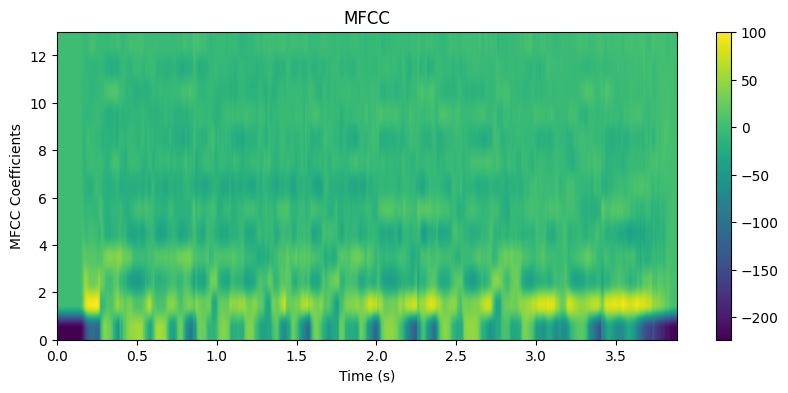

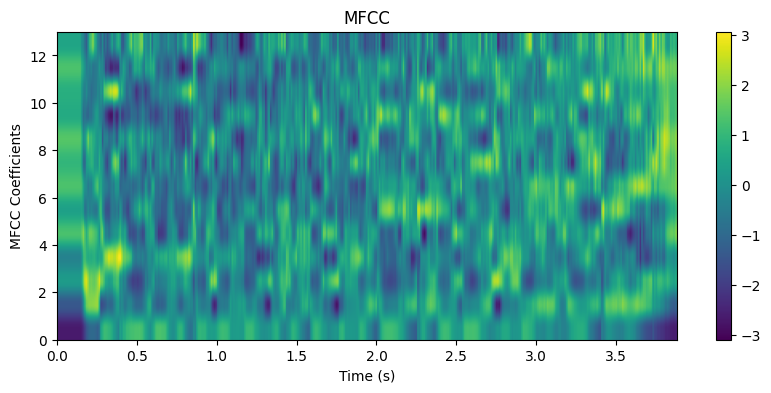

tensor([-2.6212, -1.3288,  0.3945, -0.2054,  1.4712,  0.5905,  1.4840,  1.1957,
         1.5829,  0.8113,  0.8758,  1.3990,  0.5583])
torch.Size([388, 13])


In [108]:
import matplotlib.pyplot as plt

def pre_emphasis(signal, alpha=0.097):
    return torch.cat((signal[0].unsqueeze(0), signal[1:] - alpha * signal[:-1]))

def framing(signal, frame_size, hop_length):
    return signal.unfold(0, frame_size, hop_length)

def hamming_window(frame_size):
    return torch.hamming_window(frame_size, periodic=True)

def mfcc_extraction(signal, sr, n_mfcc):
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": 400,
            "hop_length": 160,
            "n_mels": 23,
            "center": False
        }
    )
    return mfcc_transform(signal)

# Normalizing MFCCs
def normalize(mfccs):
    mfccs_mean = torch.mean(mfccs, dim=0)
    mfccs_std = torch.std(mfccs, dim=0)
    epsilon = 1e-9
    normalized_mfccs = (mfccs - mfccs_mean) / (mfccs_std + epsilon)
    return normalized_mfccs

# Plotting MFCCs
def plot_mfccs(mfccs, sr, hop_length):
    plt.figure(figsize=(10, 4))
    mfccs = mfccs.detach().numpy()
    plt.imshow(mfccs, aspect='auto', origin='lower', 
               extent=[0, mfccs.shape[1] * hop_length / sr, 0, mfccs.shape[0]])
    plt.title('MFCC')
    plt.ylabel('MFCC Coefficients')
    plt.xlabel('Time (s)')
    plt.colorbar()
    plt.show()
    
audio_file = "/Users/santoshpandey/Desktop/ASR/code/data/OpenSLR2/wavs/nep_0258_0461984530.wav"
signal, _ = torchaudio.load(audio_file, normalize=True)
signal = signal[0] # Get the first channel
print(f"first: {signal.size()}")
print(f"Signal: {signal}")

# Resample from 48000 Hz to 16000 Hz
resample_transform = torchaudio.transforms.Resample(orig_freq=48000, new_freq=16000)
signal = resample_transform(signal)
sample_rate = 16000  # New sample rate
print(f"Second: {signal.size()}")

# Pre-emphasis
pre_emphasized_signal = pre_emphasis(signal)

# Framing
frame_size = int(0.025 * sample_rate)
hop_length = int(0.01 * sample_rate)
print(f"Frame size: {frame_size}")
print(f"Hop Length: {hop_length}")

frames = framing(signal, frame_size, hop_length)
print(f"Frames: {frames.shape}")

# Hamming window
hamming = hamming_window(frame_size)

# Apply window to each frame
windowed_frames = frames * hamming

# MFCC extraction
n_mfcc = 13
mfccs = mfcc_extraction(windowed_frames, sample_rate, n_mfcc)

# Remove the singleton dimension and transpose
mfccs = mfccs.squeeze(-1).transpose(0, 1)
mfccs = mfccs.T
print(f"MFCCs: {mfccs[0]}")
print(mfccs.shape)

normalized_mfcc = normalize(mfccs)

plot_mfccs(mfccs.T, sample_rate, hop_length)
plot_mfccs(normalized_mfcc.T, sample_rate, hop_length)
print(normalized_mfcc[0])
print(normalized_mfcc.shape)